In [379]:
import os
import fitz  # PyMuPDF
import pandas as pd
import re
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Trying with pdf - obsolete

In [198]:
def extract_text_from_pdf(pdf_path):
    doc = fitz.open(pdf_path)
    text = ""

    for page in doc:
        text += page.get_text()
    doc.close()
    return text


def find_data_in_text(text):

    # Multiline regex patterns for Nom, Prénom, Date de Naissance, and Sexe
    nom_pattern = r"(?i)NOM\s*:\s*([A-Z]+)"
    prenom_pattern = r"Prénom\s*:\s*([A-Z\s]+)"

    date_naissance_pattern = r"Date de naissance\s*:\s*(\d{2}/\d{2}/\d{4})"
    sexe_pattern = r"Sexe\s*:\s*([MF])"

    # Using re.DOTALL to ensure dot matches across newlines
    nom_match = re.search(nom_pattern, text, re.DOTALL)
    prenom_match = re.search(prenom_pattern, text, re.DOTALL)
    date_naissance_match = re.search(date_naissance_pattern, text, re.DOTALL)
    sexe_match = re.search(sexe_pattern, text, re.DOTALL)

    # Extracting matched groups, handling None
    nom = nom_match.group(1).strip() if nom_match else None
    prenom = prenom_match.group(1).strip() if prenom_match else None
    date_naissance = date_naissance_match.group(
        1) if date_naissance_match else None
    sexe = sexe_match.group(1) if sexe_match else None

    return nom, prenom, date_naissance, sexe


def process_pdf_files_in_directory(directory_path):
    data = []
    for filename in os.listdir(directory_path):
        if filename.endswith(".pdf"):
            # Extract IPP from the filename
            ipp = filename[:9]

            pdf_path = os.path.join(directory_path, filename)
            text = extract_text_from_pdf(pdf_path)

            # Extract required information using the updated function
            nom, prenom, date_naissance, sexe = find_data_in_text(text)

            # Append the extracted data including IPP
            data.append([filename, ipp, nom, prenom, date_naissance, sexe])

    return pd.DataFrame(
        data, columns=["Filename", "IPP", "Nom",
                       "Prénom", "Date de Naissance", "Sexe"]
    )

In [199]:
directory_path = "./data/data_extractMoustapha_2020:2021"
df = process_pdf_files_in_directory(directory_path)


## Going for txt files

In [380]:
def read_text_file(file_path):
    with open(file_path, "r", encoding="utf-8") as file:
        return file.read()

In [381]:
def extract_prenom_before_docteur(text):
    pattern = r"Prénom\s*:\s*([A-Z\s]+)"
    match = re.search(pattern, text, re.IGNORECASE)
    if match:
        # Extract the captured group before "Docteur"
        before_docteur = match.group(1)
        first_name = before_docteur.split()[0] if before_docteur else None
        return first_name
    return None


def extract_nom(text):
    nom_pattern = r"(?i)(^Nom\s*:\s*|Nom[\s+]*usuel\s*:\s*|Nom\s*:\s*)([A-Z]+)"
    nom_match = re.search(nom_pattern, text, re.DOTALL)
    return nom_match.group(2).strip() if nom_match else None


def extract_ddn(text):
    date_naissance_pattern = (
        r"(?i)(Date[\s+]*de[\s+]*naissance\s*:\s*)(\d{2}/\d{2}/\d{4})"
    )
    date_naissance_match = re.search(date_naissance_pattern, text, re.DOTALL)
    return date_naissance_match.group(2).strip() if date_naissance_match else None


def extract_sex(text):
    sexe_pattern = r"Sexe\s*:\s*([MF])"
    sexe_match = re.search(sexe_pattern, text, re.DOTALL)
    return sexe_match.group(1) if sexe_match else None


def extract_ddprelevement(text):
    date_prelevement_pattern = (
        r"(?i)(Prélevé le \s*:\s*|Prélevé[\s+]*le\s*:\s*)(\d{2}/\d{2}/\d{4})"
    )
    date_prelevement_match = re.search(date_prelevement_pattern, text, re.DOTALL)
    return date_prelevement_match.group(2) if date_prelevement_match else None


def extract_technique(text):
    # Most found pattern
    technique_pattern = r"(2\.|II\.|I\.|2/|2°/)[\s+]*(Biopsies\s+trans[ -]*bronchiques|Biopsies\s+transbronchiques|Biospies\s+transbronchiques|BTB)[\s\S+]*?Technique[^\S\r\n]*:[^\S\r\n]*([^;]+)"
    technique_match = re.search(technique_pattern, text, re.DOTALL | re.IGNORECASE)

    if not technique_match:
        # Sometimes, there isn't the numbers, only "Biopsie" in text etc..
        fallback_technique_pattern = r"(Biopsies\s+trans[ -]*bronchiques|Biopsies\s+transbronchiques|Biospies\s+transbronchiques|BTB)[\s\S+]*?Technique\s*:\s*([^;]+)"
        fallback_match = re.search(fallback_technique_pattern, text, re.DOTALL)
        if fallback_match:
            return fallback_match.group(2).strip()

        else:
            # No mention of biopsie or lavage, just the mention of techniques two times. The BTB technique is always second.
            parts = re.split(r"(?=Technique\s*:)", text, flags=re.IGNORECASE)
            two_parts_fallback_technique_pattern = r"Technique\s*:\s*([^;]+)"
            if len(parts) > 2:
                two_parts_fallback_match = re.search(
                    two_parts_fallback_technique_pattern, parts[-1], re.DOTALL
                )
                if two_parts_fallback_match:
                    return two_parts_fallback_match.group(1).strip()

            # Else, look at any mention of technique in the document
            else:
                last_fallback_technique_pattern = r"Technique\s*:\s*([^;]+)"
                last_fallback_match = re.search(
                    last_fallback_technique_pattern, text, re.DOTALL
                )
                if last_fallback_match:
                    return last_fallback_match.group(1).strip()

    return technique_match.group(3).strip() if technique_match else None


def extract_niveaux_coupes(text):
    """
    In this function we just reuse the extract_technique patterns to extract the group after the semi-colon
    """
    # Most found pattern
    technique_pattern = r"(2\.|II\.|I\.|2/|2°/)[\s+]*(Biopsies\s+trans[ -]*bronchiques|Biopsies\s+transbronchiques|Biospies\s+transbronchiques|BTB)[\s\S+]*?Technique\s*:\s*([^;]+);\s*([^n]+)"
    technique_match = re.search(technique_pattern, text, re.DOTALL | re.IGNORECASE)

    if not technique_match:
        # Sometimes, there isn't the numbers, only "Biopsie" in text etc..
        fallback_technique_pattern = r"(Biopsies\s+trans[ -]*bronchiques|Biopsies\s+transbronchiques|Biospies\s+transbronchiques|BTB)[\s\S+]*?Technique\s*:\s*([^;]+);\s*([^n]+)"
        fallback_match = re.search(fallback_technique_pattern, text, re.DOTALL)
        if fallback_match:
            return fallback_match.group(3).strip()

        else:
            # No mention of biopsie or lavage, just the mention of techniques two times. The BTB technique is always second.
            parts = re.split(r"(?=Technique\s*:)", text, flags=re.IGNORECASE)
            two_parts_fallback_technique_pattern = r"Technique\s*:\s*([^;]+);\s*([^n]+)"
            if len(parts) > 2:
                two_parts_fallback_match = re.search(
                    two_parts_fallback_technique_pattern, parts[-1], re.DOTALL
                )
                if two_parts_fallback_match:
                    return two_parts_fallback_match.group(2).strip()

            # Else, look at any mention of technique in the document
            else:
                last_fallback_technique_pattern = r"Technique\s*:\s*([^;]+);\s*([^n]+)"
                last_fallback_match = re.search(
                    last_fallback_technique_pattern, text, re.DOTALL
                )
                if last_fallback_match:
                    return last_fallback_match.group(2).strip()

    return technique_match.group(4).strip() if technique_match else None


def extract_site(text):
    site_pattern = r"(Site[\s\xa0]*:)([\S]*[^\n]+)"
    site_match = re.search(site_pattern, text, re.DOTALL)
    return site_match.group(2).strip() if site_match else None


def extract_fragment_alveolaire(text):
    frag_alveolaire_pattern = r"(Nombre[\s\xa0]*de[\s\xa0]*fragments[\s\xa0]*alvéolaires[\s\xa0]*:)([\S]*[^\n]+)"
    frag_alveolaire_match = re.search(frag_alveolaire_pattern, text, re.DOTALL)
    return frag_alveolaire_match.group(2).strip() if frag_alveolaire_match else None


def extract_bronche_bronchiole(text):
    bronche_bronchiole_pattern = r"(Bronches\/Bronchioles[\s\xa0]*:[\s\xa0]*|Bronches[\s\xa0]*\/[\s\xa0]*Bronchioles[\s\xa0]*:[\s\xa0]*)([\S]*[^\n]+)"
    bronche_bronchiole_match = re.search(bronche_bronchiole_pattern, text, re.DOTALL)
    return (
        bronche_bronchiole_match.group(2).strip() if bronche_bronchiole_match else None
    )

def extract_infiltrat(text):
    infiltrat_pattern = r"(Infiltrat[\s\xa0]*mononucléé[\s\xa0]*péri(?:-|\s*)?vasculaire[\s\xa0]*\(A0[\s\xa0]*à[\s\xa0]*A4[\s\xa0]*\/[\s\xa0]*AX\)[\s\xa0]*:*:[\s\xa0]*|Infiltrat[\s\xa0]*mononucléé[\s\xa0]*péri(?:-|\s*)?vasculaire[\s\xa0]*\(A[\s\xa0]*\)[\s\xa0]*:*:[\s\xa0]*)([\S]*[^\n]+)"
    infiltrat__match = re.search(infiltrat_pattern, text, re.DOTALL)
    return infiltrat__match.group(2).strip() if infiltrat__match else None


def extract_bronchiolite_lymph(text):
    bronchlymph_pattern = r"(Bronchiolite[\s\xa0]*lymphocytaire[\s\xa0]*\(B0[\s\xa0]*\/[\s\xa0]*1R[\s\xa0]*\/[\s\xa0]*2R[\s\xa0]*\/[\s\xa0]*BX\)[\s\xa0]*:*:[\s\xa0]*|Bronchiolite[\s\xa0]*lymphocytaire[\s\xa0]*\(B[\s\xa0]*\)[\s\xa0]*:*:[\s\xa0]*)([\w]*)"
    bronchlymph__match = re.search(bronchlymph_pattern, text, re.DOTALL)
    return bronchlymph__match.group(2).strip() if bronchlymph__match else None


def extract_infl_lymph(text):
    infl_lymph_pattern = r"(Inflammation[\s\xa0]*lymphocytaire[\s\xa0]*bronchique[\s\xa0]*\([\s\xa0]*oui[\s\xa0]*\/[\s\xa0]*non[\s\xa0]*\)[\s\xa0]*:*:[\s\xa0]*)([\w]*)"
    infl_lymph_match = re.search(infl_lymph_pattern, text, re.DOTALL)
    return infl_lymph_match.group(2).strip() if infl_lymph_match else None

def extract_bronch_obliter(text):
    bronch_obliter_pattern = r"Bronchiolite[\s\xa0]*(oblitérante|constrictive)[\s\xa0]*:*[\s\xa0]*([\w\s]*)"
    bronch_obliter_match = re.search(bronch_obliter_pattern, text, re.DOTALL)
    return bronch_obliter_match.group(2).strip() if bronch_obliter_match else None

def extract_fibroelastose(text):  # Ajouter fibrose iterstitielle ? non
    fibroelastose_pattern = r"(Fibro(?:-|\s*)?élastose[\s\xa0]*interstitielle [\s\xa0]*\([\s\xa0]*0[\s\xa0]*ou[\s\xa0]*1[\s\xa0]*\)[\s\xa0]*:*:[\s\xa0]*)([\w]*)"
    fibroelastose_match = re.search(fibroelastose_pattern, text, re.DOTALL)
    return fibroelastose_match.group(2).strip() if fibroelastose_match else None


def extract_PNN_cloisons(text):
    pnn_pattern = r"(PNN[\s\xa0]*dans[\s\xa0]*les[\s\xa0]*cloisons[\s\xa0]*alvéolaires[\s\xa0]*\(0[\s\xa0]*à[\s\xa0]*\+\+\+[\s\xa0]*\)[\s\xa0]*:*:[\s\xa0]*|PNN[\s\xa0]*dans[\s\xa0]*les[\s\xa0]*cloisons[\s\xa0]*alvéolaires[\s\xa0]*\(0[\s\xa0]*à[\s\xa0]*\+\+\+[\s\xa0]*\)[\s\xa0]*:*:[\s\xa0]*)([^\n]+)"
    pnn_match = re.search(pnn_pattern, text, re.DOTALL)
    return pnn_match.group(2).strip() if pnn_match else None


def extract_cellmono(text):
    cellmono_pattern = r"(Cellules[\s\xa0]*mononucléées[\s\xa0]*dans[\s\xa0]*les[\s\xa0]*capillaires[\s\xa0]*alvéolaires[\s\xa0]*\(0[\s\xa0]*à[\s\xa0]*\+\+\+[\s\xa0]*\)[\s\xa0]*:*:[\s\xa0]*|Cellules[\s\xa0]*mononuclées[\s\xa0]*\(lymphocytes[\s\xa0]*ou[\s\xa0]*macrophages[\s\xa0]*dans[\s\xa0]*les[\s\xa0]*cloisons[\s\xa0]*alvéolaires\)[\s\xa0]*\(0[\s\xa0]*à[\s\xa0]*\+\+\+[\s\xa0]*\)[\s\xa0]*:*:[\s\xa0]*)([\S]*[^\n]+)"
    cellmono_match = re.search(cellmono_pattern, text, re.DOTALL)
    return cellmono_match.group(2).strip() if cellmono_match else None

def extract_dilatation(text):
    dilatation_pattern = r"(Dilatation[\s\xa0]*des[\s\xa0]*capillaires[\s\xa0]*alvéolaires[\s\xa0]*\(0[\s\xa0]*à[\s\xa0]*\+\+\+[\s\xa0]*\)[\s\xa0]*:*:[\s\xa0]*)([\S]*[^\n]+)"
    dilatation_match = re.search(dilatation_pattern, text, re.DOTALL)
    return dilatation_match.group(2).strip() if dilatation_match else None

def extract_oedeme(text):
    oedeme_pattern = r"((Œdème|Oedème)[\s\xa0]*des[\s\xa0]*cloisons[\s\xa0]*alvéolaires[\s\xa0]*\(0[\s\xa0]*à[\s\xa0]*\+\+\+[\s\xa0]*\)[\s\xa0]*:*:[\s\xa0]*)([\S]*[^\n])"
    oedeme_match = re.search(oedeme_pattern, text, re.DOTALL)
    return oedeme_match.group(3).strip() if oedeme_match else None

def extract_hyperplasie(text):
    hyperplasie_pattern = r"(Hyperplasie[\s\xa0]*pneumocytaire[\s\xa0]*\(0[\s\xa0]*à[\s\xa0]*\+\+\+[\s\xa0]*\)[\s\xa0]*:*:[\s\xa0]*)([\S]*[^\n])"
    hyperplasie_match = re.search(hyperplasie_pattern, text, re.DOTALL)
    return hyperplasie_match.group(2).strip() if hyperplasie_match else None

def extract_PNN_espace(text):
    pnn_pattern = r"(PNN[\s\xa0]*dans[\s\xa0]*les[\s\xa0]*espaces[\s\xa0]*alvéolaires[\s\xa0]*\(0[\s\xa0]*à[\s\xa0]*\+\+\+[\s\xa0]*\)[\s\xa0]*:*:[\s\xa0]*|PNN[\s\xa0]*dans[\s\xa0]*les[\s\xa0]*espaces[\s\xa0]*alvéolaires[\s\xa0]*\(0[\s\xa0]*à[\s\xa0]*\+\+\+[\s\xa0]*\)[\s\xa0]*:*:[\s\xa0]*)([^\n]+)"
    pnn_match = re.search(pnn_pattern, text, re.DOTALL)
    return pnn_match.group(2).strip() if pnn_match else None

def extract_thrombifib(text):
    tbf_pattern = r"(Thrombi[\s\xa0]*fibrineux[\s\xa0]*dans[\s\xa0]*les[\s\xa0]*capillaires[\s\xa0]*alvéolaires[\s\xa0]*\(0[\s\xa0]*à[\s\xa0]*\+\+\+[\s\xa0]*\)[\s\xa0]*:*:[\s\xa0]*)([\S]*[^\n])"
    tbf_match = re.search(tbf_pattern, text, re.DOTALL)
    return tbf_match.group(2).strip() if tbf_match else None

def extract_debriscell(text):
    debris_pattern = r"(Débris[\s\xa0]*cellulaires[\s\xa0]*dans[\s\xa0]*les[\s\xa0]*cloisons[\s\xa0]*alvéolaires[\s\xa0]*\(0[\s\xa0]*à[\s\xa0]*\+\+\+[\s\xa0]*\)[\s\xa0]*:*:[\s\xa0]*)([\S]*[^\n])"
    debris_match = re.search(debris_pattern, text, re.DOTALL)
    return debris_match.group(2).strip() if debris_match else None

def extract_epaissfibreux(text):
    epaiss_pattern = r"(Epaississement[\s\xa0]*fibreux[\s\xa0]*des[\s\xa0]*cloisons[\s\xa0]*alvéolaires[\s\xa0]*(?:\w*)?\(0[\s\xa0]*à[\s\xa0]*\+\+\+[\s\xa0]*\)[\s\xa0]*:*:[\s\xa0]*)([\S]*[^\n])"
    epaiss_match = re.search(epaiss_pattern, text, re.DOTALL)
    return epaiss_match.group(2).strip() if epaiss_match else None

def extract_macrophages(text):
    pattern = r"(Macrophages[\s\xa0]*dans[\s\xa0]*les[\s\xa0]*espaces[\s\xa0]*alvéolaires[\s\xa0]*\(0[\s\xa0]*à[\s\xa0]*\+\+\+[\s\xa0]*\)[\s\xa0]*:*:[\s\xa0]*)([\S]*[^\n])"
    match = re.search(pattern, text, re.DOTALL)
    return match.group(2).strip() if match else None

def extract_bourgeons(text):
    pattern = r"(Bourgeons[\s\xa0]*conjonctifs[\s\xa0]*dans[\s\xa0]*les[\s\xa0]*espaces[\s\xa0]*alvéolaires[\s\xa0]*\(0[\s\xa0]*à[\s\xa0]*\+\+\+[\s\xa0]*\)[\s\xa0]*:*:[\s\xa0]*)([\S]*[^\n])"
    match = re.search(pattern, text, re.DOTALL)
    return match.group(2).strip() if match else None

def extract_bourgeons(text):
    pattern = r"(Bourgeons[\s\xa0]*conjonctifs[\s\xa0]*dans[\s\xa0]*les[\s\xa0]*espaces[\s\xa0]*alvéolaires[\s\xa0]*\(0[\s\xa0]*à[\s\xa0]*\+\+\+[\s\xa0]*\)[\s\xa0]*:*:[\s\xa0]*)([\S]*[^\n])"
    match = re.search(pattern, text, re.DOTALL)
    return match.group(2).strip() if match else None

def extract_hematies(text):
    pattern = r"(Hématies[\s\xa0]*dans[\s\xa0]*les[\s\xa0]*espaces[\s\xa0]*alvéolaires[\s\xa0]*\(0[\s\xa0]*à[\s\xa0]*\+\+\+[\s\xa0]*\)[\s\xa0]*:*:[\s\xa0]*)([\S]*[^\n])"
    match = re.search(pattern, text, re.DOTALL)
    return match.group(2).strip() if match else None

def extract_membranes(text):
    pattern = r"(Membranes[\s\xa0]*hyalines[\s\xa0]*\(0[\s\xa0]*à[\s\xa0]*\+\+\+[\s\xa0]*\)[\s\xa0]*:*:[\s\xa0]*)([\S]*[^\n])"
    match = re.search(pattern, text, re.DOTALL)
    return match.group(2).strip() if match else None

def extract_fibrines(text):
    pattern = r"(Fibrine[\s\xa0]*dans[\s\xa0]*les[\s\xa0]*espaces[\s\xa0]*alvéolaires[\s\xa0]*\(0[\s\xa0]*à[\s\xa0]*\+\+\+[\s\xa0]*\)[\s\xa0]*:*:[\s\xa0]*)([\S]*[^\n])"
    match = re.search(pattern, text, re.DOTALL)
    return match.group(2).strip() if match else None

def extract_inflspsbb(text):
    pattern = r"(Inflammation[\s\xa0]*sous(\-|[\s\xa0])?pleurale,[\s\xa0]*septale,[\s\xa0]*bronchique[\s\xa0]*ou[\s\xa0]*bronchiolaire[\s\xa0]*\(0[\s\xa0]*à[\s\xa0]*\+\+\+[\s\xa0]*\)[\s\xa0]*:*:[\s\xa0]*)([\S]*[^\n])"
    match = re.search(pattern, text, re.DOTALL)
    return match.group(3).strip() if match else None

def extract_inflspsbb(text):
    pattern = r"(Inflammation[\s\xa0]*sous(\-|[\s\xa0])?pleurale,[\s\xa0]*septale,[\s\xa0]*bronchique[\s\xa0]*ou[\s\xa0]*bronchiolaire[\s\xa0]*\(0[\s\xa0]*à[\s\xa0]*\+\+\+[\s\xa0]*\)[\s\xa0]*:*:[\s\xa0]*)([\S]*[^\n])"
    match = re.search(pattern, text, re.DOTALL)
    return match.group(3).strip() if match else None

def extract_BALT(text):
    pattern = r"(BALT[\s\xa0]*\(oui\/non\)[\s\xa0]*:*:[\s\xa0]*)([\S]*[^\n])"
    match = re.search(pattern, text, re.DOTALL)
    return match.group(2).strip() if match else None

def extract_thrombus(text): 
    pattern = r"(Thrombus[\s\xa0]*fibrino(\-|[\s\xa0]|)?cruorique[\s\xa0]*(\(oui\/non\)|)?[\s\xa0]*:*:[\s\xa0]*)([\S]*[^\n])"
    match = re.search(pattern, text, re.DOTALL)
    return match.group(4).strip() if match else None

def extract_necrose(text): 
    pattern = r"(Nécrose[\s\xa0]*ischémique[\s\xa0]*(\(oui\/non\)|)?[\s\xa0]*:*:[\s\xa0]*)([\S]*[^\n])"
    match = re.search(pattern, text, re.DOTALL)
    return match.group(3).strip() if match else None

def extract_incluvirales(text): 
    pattern = r"(Inclusions[\s\xa0]*virales[\s\xa0]*(\(oui\/non\)|)?[\s\xa0]*:*:[\s\xa0]*)([\S]*[^\n])"
    match = re.search(pattern, text, re.DOTALL)
    return match.group(3).strip() if match else None

def extract_agentpatho(text):
    pattern = r"(Agent[\s\xa0]*pathogène[\s\xa0]*(\(oui\/non\)|)?[\s\xa0]*:*:[\s\xa0]*)([\S]*[^\n])"
    match = re.search(pattern, text, re.DOTALL)
    return match.group(3).strip() if match else None 

def extract_eosino(text):
    pattern = r"(Eosinophilie[\s\xa0]*(\(interstitielle\/alvéolaire\)|)?[\s\xa0]*(\(oui\/non\)|)?[\s\xa0]*:*:[\s\xa0]*)([\S]*[^\n])"
    match = re.search(pattern, text, re.DOTALL)
    return match.group(4).strip() if match else None     

def extract_remodelage_vasculaire(text):
    pattern = r"(Remodelage[\s\xa0]*vasculaire[\s\xa0]*[\s\xa0]*(\(oui\/non\)|)?[\s\xa0]*:*:[\s\xa0]*)([\S]*[^\n])"
    match = re.search(pattern, text, re.DOTALL)
    return match.group(3).strip() if match else None   

def extract_mat_etranger_inhalation(text):
    pattern = r"(Matériel[\s\xa0]*étranger[\s\xa0]*d’inhalation[\s\xa0]*(\(oui\/non\)|)?[\s\xa0]*:*:[\s\xa0]*)([\S]*[^\n])"
    match = re.search(pattern, text, re.DOTALL)
    return match.group(3).strip() if match else None  

def extract_conclusion(text):
    pattern = r"(Conclusion[\s\xa0]*(:.*|)?)([\s\S]*)"
    match = re.search(pattern, text, re.DOTALL | re.IGNORECASE)
    return match.group(3).strip() if match else None  


In [382]:
def process_text_files_in_directory(directory_path):
    data = []
    for filename in os.listdir(directory_path):
        if filename.endswith(".txt"):
            ipp = filename[:9]
            file_path = os.path.join(directory_path, filename)
            text = read_text_file(file_path)
            nom = extract_nom(text)
            prenom = extract_prenom_before_docteur(text)
            ddn = extract_ddn(text)
            sexe = extract_sex(text)
            date_prelevement = extract_ddprelevement(text)
            technique = extract_technique(text)
            niveaux = extract_niveaux_coupes(text)
            site = extract_site(text)
            frag_alv = extract_fragment_alveolaire(text)
            bronche_bronchiole = extract_bronche_bronchiole(text)
            infiltrat = extract_infiltrat(text)
            bronch_lymph = extract_bronchiolite_lymph(text)
            infl_lymph = extract_infl_lymph(text)
            bronch_obliter = extract_bronch_obliter(text)
            fibro_elastose = extract_fibroelastose(text)
            pnn_cloisons = extract_PNN_cloisons(text)
            cellmono = extract_cellmono(text)
            dilatation = extract_dilatation(text)
            oedeme = extract_oedeme(text)
            hyperplasie = extract_hyperplasie(text)
            pnn_espaces = extract_PNN_espace(text)
            tbf = extract_thrombifib(text)
            debris = extract_debriscell(text)
            epaiss_fibreux = extract_epaissfibreux(text)
            macrophages = extract_macrophages(text)
            bourgeons = extract_bourgeons(text)
            hematies = extract_hematies(text)
            membranes = extract_membranes(text)
            fibrines = extract_fibrines(text)
            inflspbb = extract_inflspsbb(text)
            balt = extract_BALT(text)
            thrombus = extract_thrombus(text)
            necrose = extract_necrose(text)
            inclus_virale = extract_incluvirales(text)
            agent_patho = extract_agentpatho(text)
            eosino = extract_eosino(text)
            remodelage_vasculaire = extract_remodelage_vasculaire(text)
            mat_etranger_inhalation = extract_mat_etranger_inhalation(text)
            conclusion = extract_conclusion(text)
            data.append(
                [
                    filename,
                    ipp,
                    nom,
                    prenom,
                    ddn,
                    sexe,
                    date_prelevement,
                    technique,
                    niveaux,
                    site,
                    frag_alv,
                    bronche_bronchiole,
                    infiltrat,
                    bronch_lymph,
                    infl_lymph,
                    bronch_obliter,
                    fibro_elastose,
                    pnn_cloisons,
                    cellmono,
                    dilatation,
                    oedeme,
                    tbf,
                    debris,
                    epaiss_fibreux,
                    hyperplasie,
                    pnn_espaces,
                    macrophages,
                    bourgeons,
                    hematies,
                    membranes,
                    fibrines,
                    inflspbb,
                    balt,
                    thrombus,
                    necrose,
                    inclus_virale,
                    agent_patho,
                    eosino,
                    remodelage_vasculaire,
                    mat_etranger_inhalation,
                    conclusion
                    
                ]
            )

    return pd.DataFrame(
        data,
        columns=[
            "Filename",
            "IPP",
            "Nom",
            "Prénom",
            "Date de naissance",
            "Sexe",
            "Date de Prélèvement",
            "Technique",
            "Niveaux de coupes",
            "Site",
            "Nombre de fragment alvéolaire",
            "Bronches/Bronchioles",
            "Infiltrat",
            "Bronchiolite Lymphocytaire",
            "Inflammation Lymphocytaire",
            "Bronchiolite oblitérante",
            "Fibro-élastose interstitielle",
            "PNN dans les cloisons alvéolaires",
            "Cellules mononucléées",
            "Dilatation des capillaires alvéolaires",
            "Œdème des cloisons alvéolaires",
            "Thrombi fibrineux dans les capillaires alvéolaires",
            "Débris cellulaires dans les cloisons alvéolaires",
            "Epaississement fibreux des cloisons alvéolaires",
            "Hyperplasie pneumocytaire",
            "PNN dans les espaces alvéolaires",
            "Macrophages dans les espaces alvéolaires",
            "Bourgeons conjonctifs dans les espaces alvéolaires",
            "Hématies dans les espaces alvéolaires",
            "Membranes hyalines",
            "Fibrine dans les espaces alvéolaires",
            "Inflammation sous-pleurale, septale, bronchique ou bronchiolaire",
            "BALT",
            "Thrombus fibrino-cruorique",
            "Nécrose ischémique",
            "Inclusions virales",
            "Agent pathogène",
            "Eosinophilie (interstitielle/alvéolaire)",
            "Remodelage vasculaire",
            "Matériel étranger d’inhalation",
            "Conclusion",
        ],
    )


# Replace 'path_to_your_directory_with_txts' with your directory's path
directory_path = "./data/data_extractMoustapha_2020:2021"
df = process_text_files_in_directory(directory_path)

In [383]:
df

,Filename,IPP,Nom,Prénom,Date de naissance,Sexe,Date de Prélèvement,Technique,Niveaux de coupes,Site,...,"Inflammation sous-pleurale, septale, bronchique ou bronchiolaire",BALT,Thrombus fibrino-cruorique,Nécrose ischémique,Inclusions virales,Agent pathogène,Eosinophilie (interstitielle/alvéolaire),Remodelage vasculaire,Matériel étranger d’inhalation,Conclusion
0,300531886_69018907-395A-434F-9EAB-B2A9642866EA...,300531886,BOUTARD,BRUNO,04/05/1961,M,31/03/2021,HES,16,non précisé,...,0,non,non,non,non,non,non,non,non,1/ Lavage broncho alvéolaire : ...
1,300701581_C8216C08-75B0-4744-AB27-3AE0A89B94C4...,300701581,CAZEAU,Jean,28/05/1958,M,24/10/2021,HES,16,LID + LM,...,0,non,non,non,non,non,non,non,non,
2,300676564_7278152A-DC79-4712-9856-19494341CAB2...,300676564,ROLI,JULIEN,08/06/1981,M,28/05/2020,HES,16,,...,None,None,0,0,0,None,None,None,None,Lavage bronchiolo-alvéolaire de cellularité él...
3,300720938_6C09898C-B815-432C-96F4-9759FBAA74CB...,300720938,GUERN,LAURENCE,01/12/1970,F,13/09/2021,HES,16,LIG,...,0,non,non,non,non,non,non,non,non,
4,300554737_3D17E344-E143-4B89-BCF4-30D55CBB1FF4...,300554737,CHARNAY,CYRIL,06/06/1993,M,26/03/2020,HES,16,,...,None,None,0,0,0,None,None,None,None,Lavage bronchiolo-alvéolaire de ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1049,300553661_4C54ECD5-BFBD-43AA-8295-39F30E33A3C8...,300553661,NUSSBAUMER,MYRTILLE,23/04/2001,F,24/11/2021,HES,16,LID + LM,...,0,non,non,non,non,no,non,non,non,
1050,300670280_5A7A38FB-F732-4E34-898E-72D44F214041...,300670280,ARMAND,DANIEL,15/05/1956,M,03/03/2020,HES,16,LID,...,None,None,0,0,0,None,None,None,None,Lavage bronchiolo-alvéolaire de cellularité un...
1051,300732450_DEBAB80B-F589-41AE-AA08-5F2E0D83659F...,300732450,BOYER,FABIOLA,26/02/1988,F,06/07/2021,HES,16,LID,...,0,non,non,non,non,non,non,non,non,Lavage bronchiolo-alvéolaire de cel...
1052,300409902_C9E9AFE4-1FBE-4C3E-9E2E-31B1706285AA...,300409902,BOGE,GILLES,14/10/1956,M,04/08/2020,HES,16,LM/LID,...,None,None,0,0,0,None,None,None,None,I – Biopsies transbronchiques (LID/LM...


## Verification

In [384]:
import pandas as pd
import matplotlib.pyplot as plt

def summarize_verification_steps(df, column_name):
    summary = []

    # Step 1: Value Counts
    value_counts = df[column_name].value_counts()
    summary.append({'Step Description': 'Value Counts', 'Column Name': column_name, 'Result': value_counts})

    # Step 2: Identify Missing Values
    missing_values_count = df[column_name].isna().sum()
    summary.append({'Step Description': 'Missing Values Count', 'Column Name': column_name, 'Result': missing_values_count})

    # Extract rows with missing values for further analysis
    df_na = df[df[column_name].isna()]

    # Step 3: Extract and Transform Dates
    if 'Date de Prélèvement' in df_na.columns:
        df_na['Date de Prélèvement'] = pd.to_datetime(df_na['Date de Prélèvement'], dayfirst=True)
        df_na['Year'] = df_na['Date de Prélèvement'].dt.year
        year_counts = df_na['Year'].value_counts().sort_index()
        summary.append({'Step Description': 'Year Extraction & Counts', 'Column Name': 'Date de Prélèvement', 'Result': year_counts,})

    # Step 4: Plot Frequency by Year (if applicable)
    # This step involves visualization, which can't be directly represented in the DataFrame but can be noted.
    if 'Year' in df_na.columns:
        summary.append({'Step Description': 'Frequency Plot by Year', 'Column Name': 'Year', 'Result': 'Plot generated'})

        # Plotting is done outside the DataFrame since it's not a textual result
        ax = year_counts.plot(kind='bar')
        plt.xlabel('Year')
        plt.ylabel('Frequency')
        plt.title('Frequency of missing information by year')
        for p in ax.patches:
            ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center', xytext=(0, 5), textcoords='offset points')
        plt.show()

    return pd.DataFrame(summary)


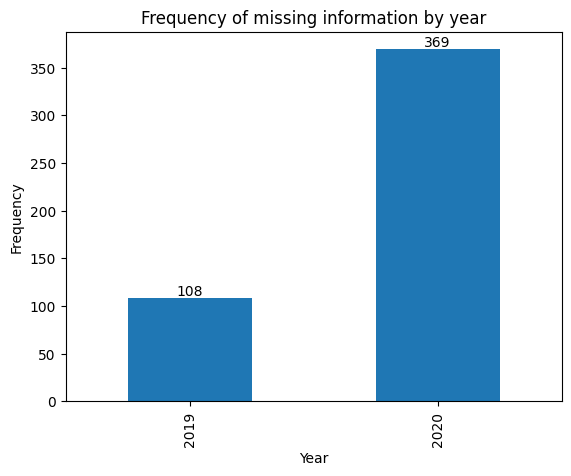

,Step Description,Column Name,Result
0,Value Counts,Matériel étranger d’inhalation,Matériel étranger d’inhalation non 514 NON ...
1,Missing Values Count,Matériel étranger d’inhalation,477
2,Year Extraction & Counts,Date de Prélèvement,"Year 2019 108 2020 369 Name: count, dtyp..."
3,Frequency Plot by Year,Year,Plot generated


In [388]:
# Apply the function to your DataFrame and specific column
df_summary = summarize_verification_steps(df, df.columns[-2])
df_summary